In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `tf.keras` framework.


# READ AND PREPROCESS

In [2]:
# Function to read images from a folder
def read_images_from_folder(folder_path):
    image_list = []
    mask_list = []
    images_folder = os.path.join(folder_path, 'images')
    masks_folder = os.path.join(folder_path, 'masks')


    # Read images from the images folder
    for filename in os.listdir(images_folder):
        img_path = os.path.join(images_folder, filename)
        if os.path.isfile(img_path):
            image = cv2.imread(img_path)
            if image is not None:
                image_list.append(image)

    # Read images from the masks folder
    for filename in os.listdir(masks_folder):
        mask_path = os.path.join(masks_folder, filename)
        if os.path.isfile(mask_path):
            mask = cv2.imread(mask_path)
            if mask is not None:
                mask_list.append(mask)

    return image_list, mask_list

# Main function to read images from all folders
def read_images_from_all_folders(num_folders):
    all_image_list = []
    all_mask_list = []
    for i in range(1, num_folders + 1):
        folder_path = os.path.join(f'Tile {i}')
        images, masks = read_images_from_folder(folder_path)
        all_image_list.extend(images)
        all_mask_list.extend(masks)
    return all_image_list, all_mask_list


images,masks = read_images_from_all_folders(8)

for i in range(len(images)):
    images[i] = cv2.resize(images[i],(256,256))
    
for i in range(len(masks)):
    masks[i] = cv2.resize(masks[i],(256,256))

images = np.array(images)
masks = np.array(masks)

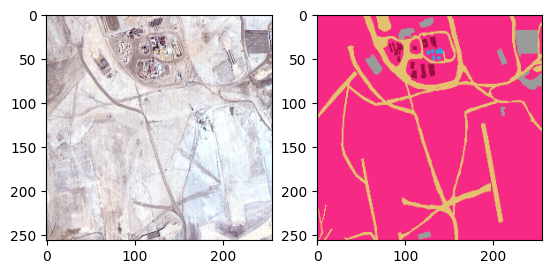

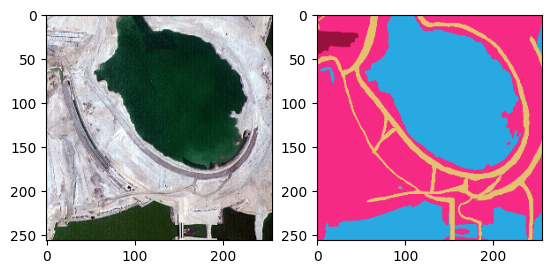

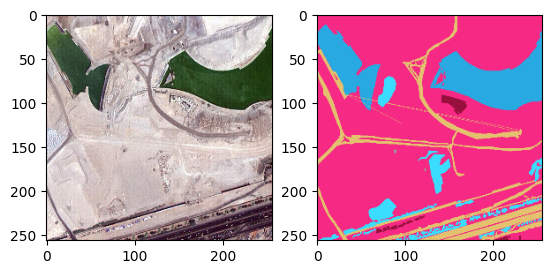

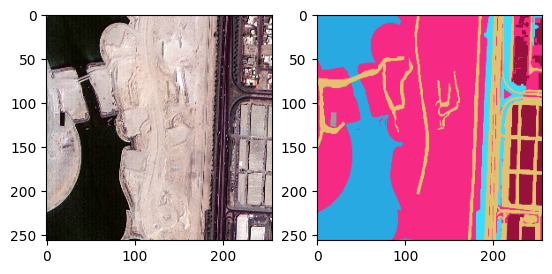

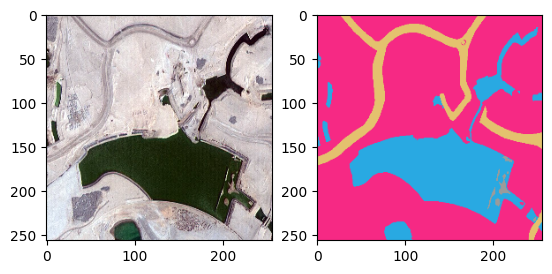

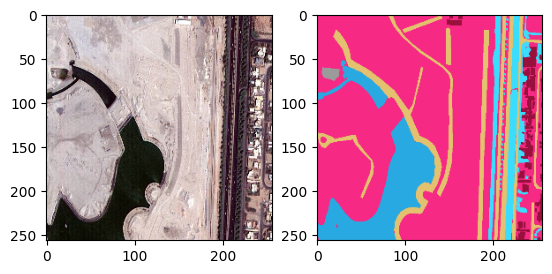

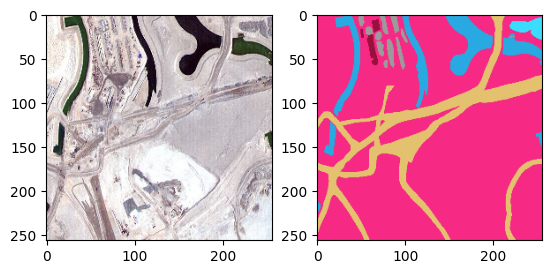

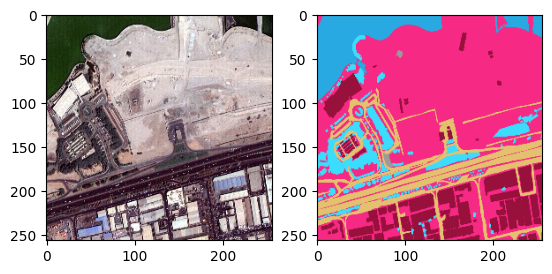

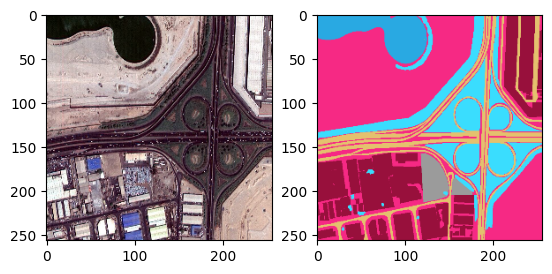

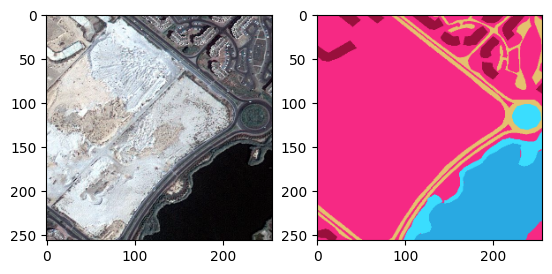

In [35]:
for i in range(10):
    plt.subplot(121)
    plt.imshow(images[i])
    plt.subplot(122)
    plt.imshow(masks[i])
    plt.show()

# RGB COLOR CONVERSION FROM HEX

**RGB to HEX Conversion:**

To convert RGB (Red, Green, Blue) values to HEX (Hexadecimal) format, follow these steps:

1. **Divide Each RGB Value by 16:**
   - Take each RGB value and divide it by 16 using integer division (ignoring any remainder).
   - The quotient represents the first hexadecimal digit.
   - The remainder represents the second hexadecimal digit.
   - If the quotient is between 10 and 15, it is represented by the letters A to F, where A=10, B=11, C=12, D=13, E=14, and F=15.

2. **Write Down the HEX Code:**
   - Combine the hexadecimal digits obtained from each RGB value to form the HEX code.

**Example:**

Given RGB values: R=201, G=16, B=152

1. **Convert R=201 to HEX:**
   - Divide 201 by 16:
     - Quotient = 12, Remainder = 9
   - The quotient 12 corresponds to 'C', and the remainder 9 corresponds to '9'.
   - So, the HEX code for R is C9.

2. **Convert G=16 to HEX:**
   - Divide 16 by 16:
     - Quotient = 1, Remainder = 0
   - The quotient 1 corresponds to '1', and the remainder 0 corresponds to '0'.
   - So, the HEX code for G is 10.

3. **Convert B=152 to HEX:**
   - Divide 152 by 16:
     - Quotient = 9, Remainder = 8
   - The quotient 9 corresponds to '9', and the remainder 8 corresponds to '8'.
   - So, the HEX code for B is 98.

**Combining the HEX codes:**
- R=201 converts to C9
- G=16 converts to 10
- B=152 converts to 98

Therefore, the HEX code for the RGB values (201, 16, 152) is #C91098.

**Calculating RGB from HEX: #3C1098**

To calculate the RGB (Red, Green, Blue) values from the given HEX code (#3C1098), follow these steps:

1. **Break down the HEX code into its components:**
   - The HEX code consists of three pairs of hexadecimal digits: 3C, 10, and 98.

2. **Convert each pair from HEX to decimal:**
   - For each pair, multiply the first digit by 16 and add the result to the value of the second digit.

3. **Assign the resulting values to RGB:**
   - The first pair (3C) corresponds to Red (R).
   - The second pair (10) corresponds to Green (G).
   - The third pair (98) corresponds to Blue (B).

**Conversion:**

1. For 3C:
   - (3 * 16) + 12 = 48 + 12 = 60

2. For 10:
   - (1 * 16) + 0 = 16 + 0 = 16

3. For 98:
   - (9 * 16) + 8 = 144 + 8 = 152

**Resulting RGB values:**
- Red (R): 60
- Green (G): 16
- Blue (B): 152

Therefore, the RGB values corresponding to the HEX code #3C1098 are R=60, G=16, and B=152.

In [3]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))[::-1] # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))[::-1] #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))[::-1] #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))[::-1] #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))[::-1] #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))[::-1] #155, 155, 155

In [4]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(masks.shape[0]):
    label = rgb_to_2D_label(masks[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


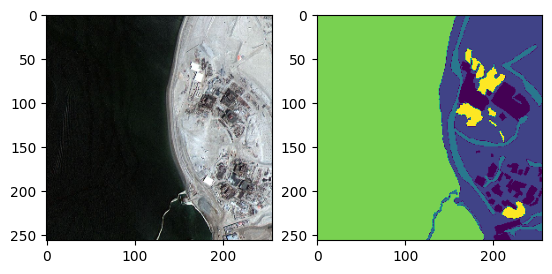

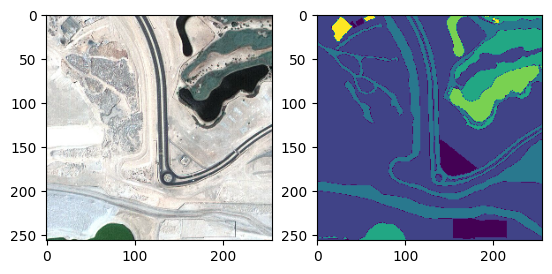

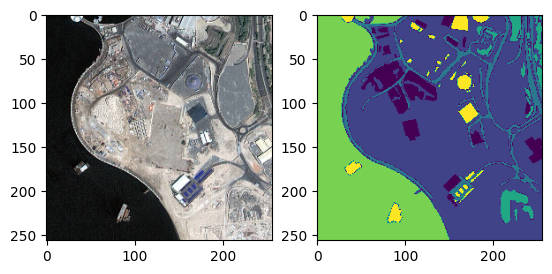

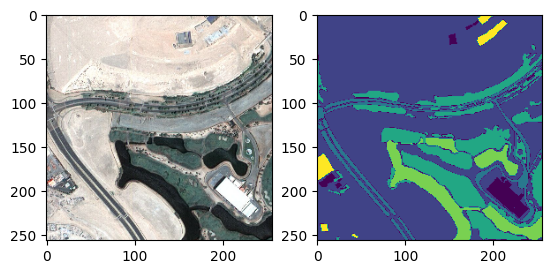

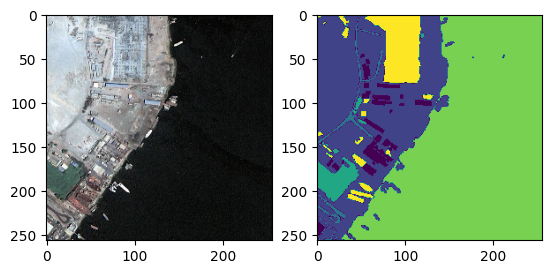

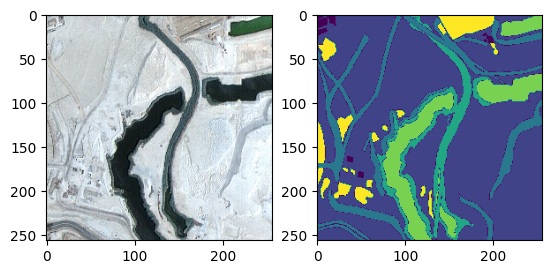

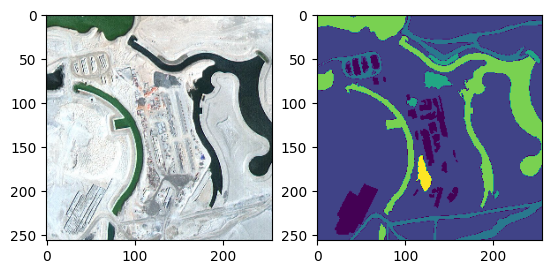

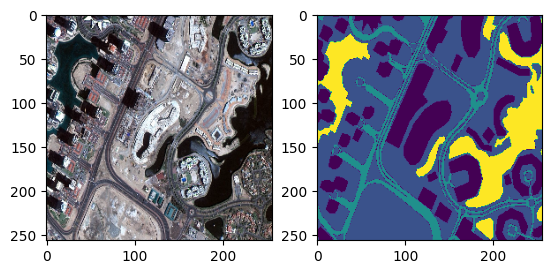

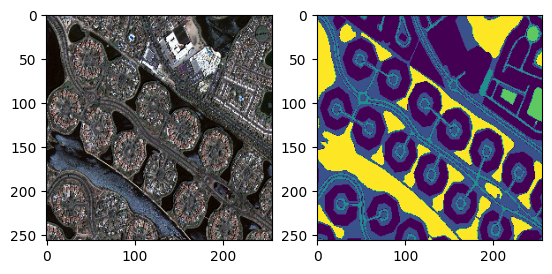

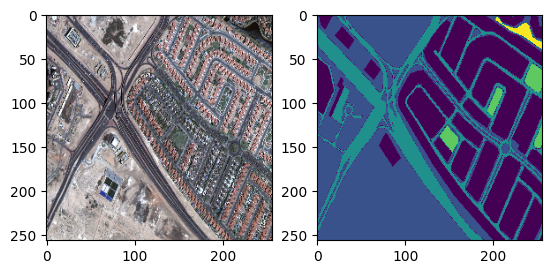

In [37]:
for i in range(20,30):
    plt.subplot(121)
    plt.imshow(images[i])
    plt.subplot(122)
    plt.imshow(labels[i])
    plt.show()

# MODELLING

In [6]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size = 0.20, random_state = 42)




weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

In [9]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [10]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

2024-04-08 20:48:43.676821: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-08 20:48:43.676845: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-04-08 20:48:43.676853: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-04-08 20:48:43.677208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-08 20:48:43.677239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

 conv2d_transpose_3 (Conv2D  (None, 256, 256, 16)         2064      ['conv2d_15[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 256, 256, 32)         0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'conv2d_1[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 256, 256, 16)         4624      ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_16[0][0]']           
                                                                                                  
 conv2d_17

2024-04-08 20:48:44.712049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4823 - accuracy: 0.2091 - jacard_coef: 0.1238

2024-04-08 20:48:48.487386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 5s 633ms/step - loss: 1.4823 - accuracy: 0.2091 - jacard_coef: 0.1238 - val_loss: 1.3108 - val_accuracy: 0.3962 - val_jacard_coef: 0.2471
Epoch 2/100
4/4 [==============================] - 1s 259ms/step - loss: 1.3534 - accuracy: 0.3892 - jacard_coef: 0.2509 - val_loss: 1.3484 - val_accuracy: 0.4305 - val_jacard_coef: 0.2746
Epoch 3/100
4/4 [==============================] - 1s 249ms/step - loss: 1.3240 - accuracy: 0.4566 - jacard_coef: 0.3031 - val_loss: 1.3421 - val_accuracy: 0.4393 - val_jacard_coef: 0.2816
Epoch 4/100
4/4 [==============================] - 1s 247ms/step - loss: 1.3084 - accuracy: 0.4795 - jacard_coef: 0.3223 - val_loss: 1.3399 - val_accuracy: 0.4425 - val_jacard_coef: 0.2840
Epoch 5/100
4/4 [==============================] - 1s 253ms/step - loss: 1.3016 - accuracy: 0.4868 - jacard_coef: 0.3230 - val_loss: 1.3340 - val_accuracy: 0.4461 - val_jacard_coef: 0.2867
Epoch 6/100
4/4 [==============================] - 1s 248ms/step - 

4/4 [==============================] - 1s 245ms/step - loss: 0.9968 - accuracy: 0.5773 - jacard_coef: 0.2738 - val_loss: 1.0050 - val_accuracy: 0.5016 - val_jacard_coef: 0.2243
Epoch 45/100
4/4 [==============================] - 1s 245ms/step - loss: 0.9957 - accuracy: 0.5824 - jacard_coef: 0.2683 - val_loss: 1.0060 - val_accuracy: 0.5129 - val_jacard_coef: 0.2331
Epoch 46/100
4/4 [==============================] - 1s 246ms/step - loss: 0.9947 - accuracy: 0.5854 - jacard_coef: 0.2821 - val_loss: 1.0050 - val_accuracy: 0.4797 - val_jacard_coef: 0.2112
Epoch 47/100
4/4 [==============================] - 1s 246ms/step - loss: 0.9959 - accuracy: 0.5774 - jacard_coef: 0.2755 - val_loss: 1.0054 - val_accuracy: 0.4608 - val_jacard_coef: 0.1987
Epoch 48/100
4/4 [==============================] - 1s 245ms/step - loss: 0.9951 - accuracy: 0.5828 - jacard_coef: 0.2746 - val_loss: 1.0044 - val_accuracy: 0.4811 - val_jacard_coef: 0.2062
Epoch 49/100
4/4 [==============================] - 1s 245ms/st

4/4 [==============================] - 1s 245ms/step - loss: 0.9747 - accuracy: 0.6640 - jacard_coef: 0.3406 - val_loss: 0.9908 - val_accuracy: 0.5785 - val_jacard_coef: 0.2397
Epoch 88/100
4/4 [==============================] - 1s 245ms/step - loss: 0.9749 - accuracy: 0.6560 - jacard_coef: 0.3227 - val_loss: 0.9920 - val_accuracy: 0.5998 - val_jacard_coef: 0.2846
Epoch 89/100
4/4 [==============================] - 1s 245ms/step - loss: 0.9772 - accuracy: 0.6468 - jacard_coef: 0.3267 - val_loss: 0.9920 - val_accuracy: 0.6105 - val_jacard_coef: 0.2847
Epoch 90/100
4/4 [==============================] - 1s 246ms/step - loss: 0.9790 - accuracy: 0.6517 - jacard_coef: 0.3192 - val_loss: 0.9889 - val_accuracy: 0.5910 - val_jacard_coef: 0.2455
Epoch 91/100
4/4 [==============================] - 1s 245ms/step - loss: 0.9763 - accuracy: 0.6650 - jacard_coef: 0.3352 - val_loss: 0.9889 - val_accuracy: 0.5855 - val_jacard_coef: 0.2421
Epoch 92/100
4/4 [==============================] - 1s 248ms/st

# PREDICTION

1/1 [==============================] - 0s 17ms/step
predicted                                                                                    real


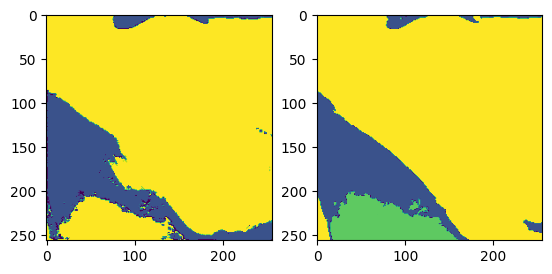

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


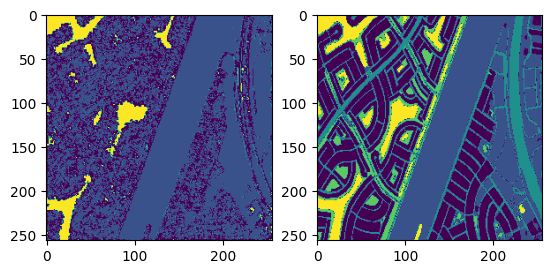

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


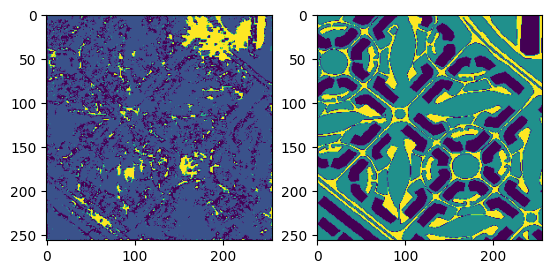

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


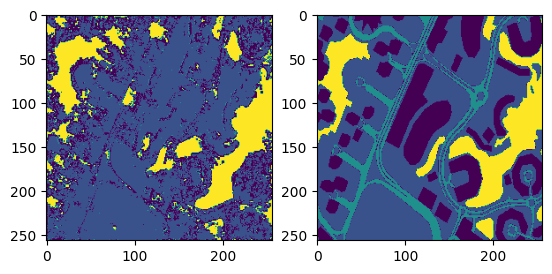

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


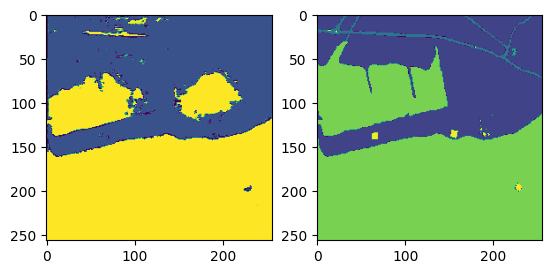

1/1 [==============================] - 0s 9ms/step
predicted                                                                                    real


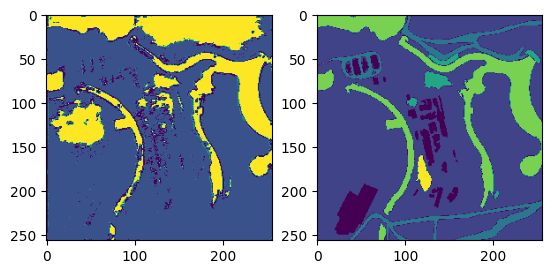

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


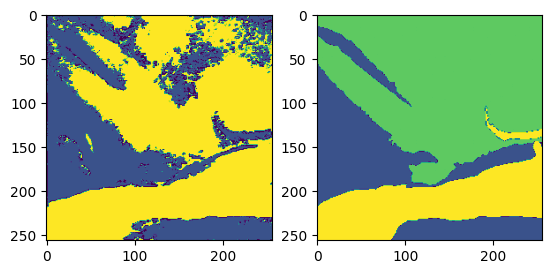

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


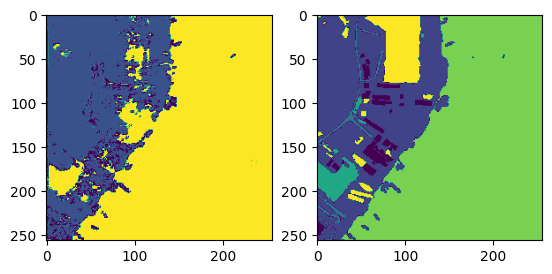

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


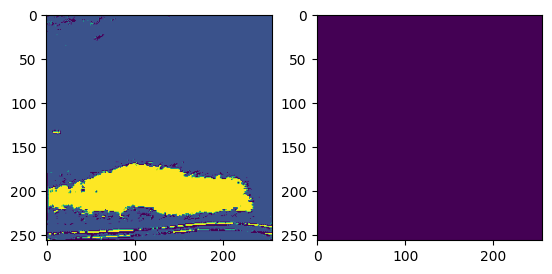

1/1 [==============================] - 0s 10ms/step
predicted                                                                                    real


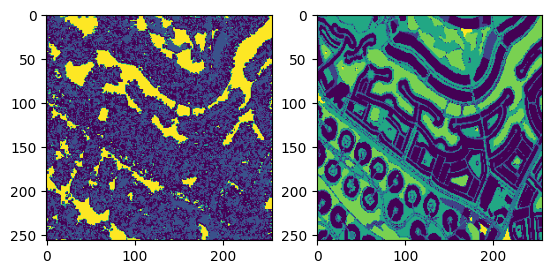

In [38]:
for i in range(30,40):
    k = model.predict(X_train[i:i+1])
    plt.subplot(121)
    plt.imshow(np.argmax(k, axis=3)[0,:,:])
    print('predicted                                                                                    real')
    plt.subplot(122)
    plt.imshow(np.argmax(y_train[i:i+1], axis=3)[0,:,:])
    plt.show()